In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms

from random import randint

In [2]:
import ResNet50_Model
import Models
from Dataset2 import dataset

In [3]:
# import thr model
import importlib
Models = importlib.reload(Models)
ResNet50_Model = importlib.reload(ResNet50_Model)
#CheXpertDataset = importlib.reload(CheXpertDataset)

In [4]:
DATA_DIR = '../vinbigdata-chestXRay/'
boxes_dir = DATA_DIR+'converted_data.csv'
images_dir = DATA_DIR+'converted'

In [5]:
train_dataset, valid_dataset, test_dataset = dataset(7, images_dir, boxes_dir, no_finding=True)

The number of training images: 11836
The number of validation images: 1480
The number of the test images: 1480


In [6]:
labels = {0:'Aortic enlargement',
          1: 'Atelectasis',
          2: 'Calcification',
         3: 'Cardiomegaly',
          4: 'Consolidation',
          5: 'ILD',
          6: 'Infiltration',
          7: 'Lung opacity',
          8: 'Nodule/Mass',
          9: 'Other lession',
          10: 'Pleural effusion',
         11: 'Pleural thickening',
          12:'Pneumothorax',
         13: 'Pulmonary fibrosis',
         14: 'No finding'}


In [7]:
class_predicted = {0:'Aortic enlargement',
                  1: 'Cardiomegaly',
                  2: 'Lung Opacity',
                  3: 'Pleural effusion',
                  4: 'Pleural thickening',
                  5: 'Pulmonary fibrosis',
                  6: 'No finding'
                  }

In [8]:
num_classes = 7
#model = Models.model(model_type='efficient', pretrained=True, requires_grad=True, res='None', num_classes=7)
model = ResNet50_Model.model(pretrained=True, requires_grad=False, num_classes=7)
checkpoint = torch.load('../outputs/best_model_50_7c.pth')
model.load_state_dict(checkpoint['model_state_dict'])
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
testloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [9]:
from test_multilabel import test
preds, true_labels, idxs, label_indices = test(model, testloader, device)

Testing the model


100%|██████████| 1480/1480 [00:37<00:00, 39.64it/s]


### Functions for plotting 

In [10]:
def superimpose_heatmap(heatmap, img):
    #print(heatmap.shape)
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))   # shape 224,224
    #invalid_values = np.isnan(resized_heatmap) | np.isinf(resized_heatmap)
    #resized_heatmap[invalid_values] = 0
    resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
#     resized_heatmap = np.uint8(255*resized_heatmap) # max: 254, min: 0
#     resized_heatmap = np.clip(resized_heatmap, 0,255) # max: 255, min: 0
   
    heatmap_gray = torch.from_numpy(resized_heatmap)
    #print(resized_heatmap.max(), resized_heatmap.min())
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET) # here is where i have 3 channels again
    #print(resized_heatmap.max(), resized_heatmap.min())
    #print(resized_heatmap.shape)
    inv_norm = transforms.Normalize((-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010), (1/0.2023, 1/0.1994, 1/0.2010))
    # superimpose the image by applying inv norm and adding the resized_heatmap
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB))*0.006+inv_norm(img.detach().cpu()[0]).permute(1,2,0)
    # Normalize superimposed_img
    superimposed_img = (superimposed_img-superimposed_img.min())/(superimposed_img.max()-superimposed_img.min())
    #print(superimposed_img.max(), superimposed_img.min())
    return superimposed_img, heatmap_gray

                                 

In [11]:
def img_show(image):
    npimg = image.numpy()
    #npimg = image
    npimg = np.transpose(npimg, (1,2,0))
    npimg = ((npimg*[0.229,0.224,0.225]) + [0.485,0.456,0.4046])
    image = np.uint8(npimg)
    image = np.clip(npimg, 0,1)
    return image

In [12]:
def draw_bbox(img, label2color, bbox, class_id):
    
    alpha=0.1
    alpha_box=0.4
    overlay_bbox=img.copy()
    overlay_text = img.copy()
    output =img.copy()
    #print(output.shape)
    

    
    for label_id, bbox in zip(class_id.values, boxes.values):
        #color = label2color[int(label_id)]
        #color = tuple(label2color[int(label_id)])
        color = label2color[int(label_id)]
      
        
        #print(f'Class: {label_id}, Color: {color}, Box: {bbox}')
        target = labels[int(label_id)]
        text_width, text_height=cv2.getTextSize(target.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
        cv2.rectangle(overlay_bbox, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)
        
        cv2.addWeighted(overlay_bbox, alpha, output, 1-alpha, 0, output)
        cv2.rectangle(overlay_text, (int(bbox[0]), int(bbox[1])-7-text_height),
                      (int(bbox[0])+text_width+2, int(bbox[1])),
                     (0,0,0), -1)
        cv2.addWeighted(overlay_text, alpha_box, output, 1-alpha_box, 0, output)
        cv2.putText(output, target.upper(), (int(bbox[0]), int(bbox[1])-3),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1, cv2.LINE_AA)
        
    return output

In [13]:
def get_boxes(DATA_DIR, idx, boxes_dir):
    
    dataset = pd.read_csv(DATA_DIR+'data_7c.csv')
    test = dataset[-1480:]
    # idx is the id of the image in the test_dataset
    idx = idx.detach().cpu().numpy()
    #print(idx)
    #index = idxs.index(idx)
    # Select the image name from the test_dataset to match with the box
    img_name = test.iloc[int(idx)].image_id
    # get the respective boxes
    boxes = pd.read_csv(boxes_dir)
    class_id = boxes.loc[boxes['image_id']==img_name, ['class_id']]
    boxes = boxes.loc[boxes['image_id']==img_name, ['x_min', 'y_min', 'x_max', 'y_max']]
    return boxes, class_id


### Apply Grad Cam for the predicted labels and extract the respective heatmaps

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Efficient_Cam(nn.Module):
    def __init__(self, net):
        super(Efficient_Cam, self).__init__()
        self.densenet = net
        features = net.features  # Access the feature extractor part of the DenseNet
        
        # Split the features into two parts: before and after the target layer
        #self.first_part_conv = nn.Sequential(*list(features.children())[:layer_index])
        self.first_part_conv = nn.Sequential(*list(features.children()))
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = net.classifier  # Access the classifier part of the DenseNet

    def forward(self, x):
        x = self.first_part_conv(x)
        
        # Register the hook to save activations
        x.register_hook(self.activations_hook)        
        #x = self.avgpool(x)
        x = F.adaptive_avg_pool2d(x, (1,1))

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        x = self.first_part_conv(x)
        return x



In [15]:
class ResNet_CAM(nn.Module):
    def __init__(self, net, layer_k):
        super(ResNet_CAM, self).__init__()
        self.resnet = net
        convs = nn.Sequential(*list(net.children())[:-1]) # exclude the linear layer  len(convs)=9, last: Adaptive Average Pooling
        self.first_part_conv = convs[:layer_k]
        self.second_part_conv = convs[layer_k:]
        self.linear = nn.Sequential(*list(net.children())[-1:])
        
        self.gradients = None # initialize gradients attribute
              
    def forward(self, x):
        x = self.first_part_conv(x)
        # register the hook
        #handle = x.register_hook(self.activations_hook)
        x.register_hook(self.activations_hook) # this hook allows the activations to 
                                               # be saved for later use
        x = self.second_part_conv(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = x.view(1,-1)
        x = self.linear(x)
        # unregister the hook
        #handle.remove()
        return x
    
    # method for the gradient extraction
    def activations_hook(self, grad):
        self.gradients=grad            # the grad parameters of the hook function is the gradients of the final output wrt
                                       # to the parameters of the output of the first part (activations)
    
    # method for the activation extraction
    def get_activations_gradient(self):         # Get the a1, a2, ..., 
        return self.gradients
    
    def get_activations(self, x):
        return self.first_part_conv(x)

In [16]:
def get_grad_cam(net, img, pred):
    net.eval()
    # Get the gradients of the output with respect to the parameters of the model
    pred.backward(retain_graph=True)
    # pull the gradients out of the model
    gradients = net.get_activations_gradient() 
    # pull the gradients across the channels, shape of gradients: (batch_size, num_channels, height, width)
    pooled_gradients = torch.mean(gradients, dim=[0,2,3])   # shape (1024, 7, 7)
    # get the activations of the last convolutional layer
    activations = net.get_activations(img).detach()  # shape (1024, 7, 7)
    # weight the channels by the corresponding gradients
    for i in range(activations.size(1)): # size(1): number of channels
        activations[:,i,:,:]*=pooled_gradients[i]
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze() # shape (7,7)
    #print(heatmap.shape)
    # Relu on the top of the heatmap
    heatmap = np.maximum(heatmap.detach().cpu(), 0)  # shape (7,7)
    heatmap /= torch.max(heatmap)
    return superimpose_heatmap(heatmap,img)

### Apply Smooth Grad

In [17]:
# Define the SmoothGrad function
def smooth_grad(model, img, num_samples=50, smoothness=0.2, threshold=0.7):
    prediction = model(img)
    prediction = torch.sigmoid(prediction).squeeze()
    mask = prediction >= threshold
    pred_label = mask.nonzero()
    pred = torch.masked_select(prediction, mask) # this is the probabalitues of the masked prediction
    n_probs = pred.shape[0]
    print(n_probs)
    smooth_cam = torch.Tensor(n_probs, 224, 224,3)
    smooth_cam_gray = torch.Tensor(n_probs, 224,224)
    for _ in range(num_samples):
        noise = torch.randn_like(img) * smoothness
        noisy_img = img+noise
        for cl in range(n_probs):
            noisy_cam, noisy_cam_gray = get_grad_cam(model, noisy_img, pred[cl])
            smooth_cam[cl] += noisy_cam
            smooth_cam_gray[cl] += noisy_cam_gray       
            
    for cl in range(n_probs):
        smooth_cam[cl] /= num_samples
        smooth_cam_gray[cl] /= num_samples
        
    return smooth_cam, smooth_cam_gray

In [18]:
def heatmaps(img, model, threshold):
    pred_all_c=model(img)
    pred_all_c = torch.sigmoid(pred_all_c).squeeze()
    # Create a mask with probabilities over 0.7
    mask = pred_all_c >= threshold
    # This is a tensor containing all the indices of the non-zero elements
    pred_label = mask.nonzero().squeeze()
    # pred tensor gives me the probabilities of the labels that are > threshold
    pred = torch.masked_select(pred_all_c, mask)
    # Take the number of probabilities over 0.7 and create a heatmap for each class
    n_probs = pred.shape[0]
    heatmap = torch.Tensor(n_probs, 224, 224,3)
    heatmap_gray = torch.Tensor(n_probs, 224, 224)
    #heatmap_gray = np.zeros((n_probs,) + (224,224))
    for cl in range(n_probs):
        heatmap[cl], heatmap_gray[cl]=get_grad_cam(model, img, pred[cl])
    return heatmap, heatmap_gray, pred_label, pred, pred_all_c

In [19]:
def get_most_important_pixels_gray(ht, pcg):
    num_pixels_to_select = int(pcg*ht.numel())
    #print(num_pixels_to_select)
    # Flatten the intensities and get indices of the sorted pixels
    flattened_heatmap = ht.flatten()
    #print(flattened_heatmap.shape)
    # sort the indices in descending order
    sorted_indices = torch.argsort(flattened_heatmap, descending=True)
    # Create a boolean mask for the top pcg important pixels
    mask = torch.zeros_like(flattened_heatmap, dtype=torch.bool)
    mask[sorted_indices[:num_pixels_to_select]]=True
    #print(mask.shape)
    final_mask = mask.view(ht.shape)
    #print(final_mask.shape)
    return final_mask
    

In [20]:
def get_the_most_important_pixels(ht, pcg):
    ht = ht.unsqueeze(dim=0).permute(0,3,1,2)  # ht [1,3,224,224]
    # get the mask of the t-pcg most important pixels
    batch_size,_,H,W = ht.size()
    # Reshape the images tensor to (batch_size, H*W)
    ht_reshaped = ht.reshape(batch_size, -1)
    # Sort the pixel values in descending order
    sorted_pixels, _ = torch.sort(ht_reshaped, descending=True)
    # Calculate the index of the pcg-th pixel in each image, actually the number of the pcg pixels
    pcg_index = int(pcg*(H*W-1))
    # Extract the tresholds
    thresholds = sorted_pixels[:, pcg_index]
    # Create a mask of pixels above the thresholds
    
    mask = ht>thresholds.view(-1,1,1,1) # [1,3,224,224]
    return mask

In [36]:
model_cam_net = Efficient_Cam(model)
model = model_cam_net.to('cpu')
model.eval()

Efficient_Cam(
  (densenet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [20]:
layer_index=111
model_cam_net = DenseNet_Cam(model, layer_index)
model = model_cam_net.to('cpu')
model.eval

NameError: name 'DenseNet_Cam' is not defined

In [21]:
layer_k=8
model_cam_net = ResNet_CAM(model, layer_k)
model = model_cam_net
#model = model_cam_net.to('cpu')
model.eval()

ResNet_CAM(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

tensor([[1, 1, 0, 0, 0, 0, 0]]) tensor([159])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


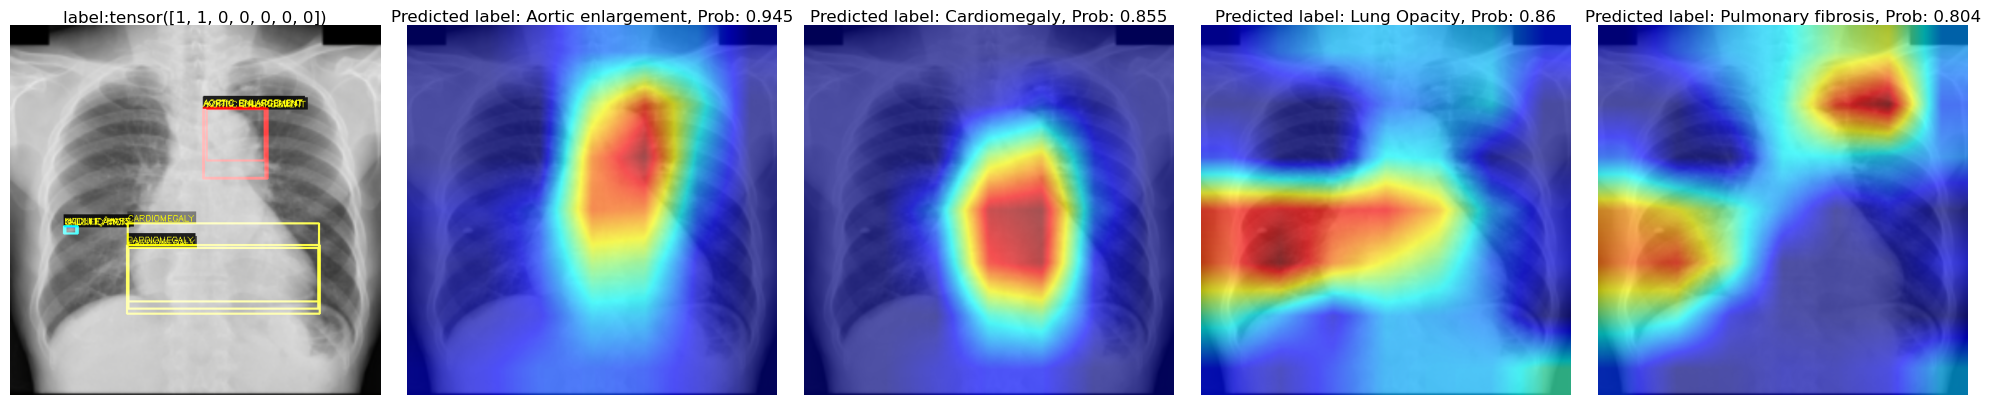

In [40]:
# choose randomly an image from testloader
it = iter(testloader)
img, label, bbox, idx=next(it)
print(label, idx)

img.requires_grad_()
image = img
# Take the heatmaps for each predicted class
heatmap, heatmap_gray, pred_label, pred, pred_all_c = heatmaps(img.to(device), model.to(device), 0.7)
# Process the image for visualization
img = img_show(img.detach().cpu().squeeze())
img = cv2.resize(img, (512,512))
#print(img.shape)
# Different color for each class_id
#label2color = {label_id: [randint(0, 255) for i in range(3)] for label_id in labels.keys()}
label2color = {
    0: (255,0,0), # Red
    1: (0,255,0), # Green
    2: (0,0,255), # blue
    3: (255,255,0), #yellow
    4: (255,0,255), # magenta
    5: (128, 128, 0), # Olive
    6: (128,0,0), # maroon
    7: (0, 255, 255), # cyan
    8: (0,128,128), # Teal
    9: (128, 128, 128), # Gray
    10: (0,128, 0), # Green(dark)
    11: (128, 0, 128), # Purple
    12: (255, 165, 0), # Orange
    13: (0, 0, 128), # Navy
    14: (255, 255, 255) # White
}

thickness=2
# Get the respective boxes
boxes, class_id = get_boxes(DATA_DIR, idx, boxes_dir)
#print(boxes.values, class_id.values)
# Take the image with the annotations
output = draw_bbox(img, label2color, boxes, class_id)

# Save the final plots
save_dir = '../outputs'
os.makedirs(save_dir, exist_ok=True)


fig, axs = plt.subplots(1, heatmap.shape[0]+1, figsize=(4*(heatmap.shape[0]+1),4))

# Ensure axs is iterable, even if there's only one subplot
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

axs[0].imshow(output)
axs[0].set_title('label:{}'.format(label.detach().cpu().squeeze()), pad=0)
axs[0].axis('off')
print(heatmap.shape[0])
# Plot the heatmap for each predicted class
for i in range(heatmap.shape[0]):
    ht = heatmap[i]  # 224, 224, 3
    ht = cv2.resize(ht.detach().cpu().numpy(), (512, 512))
    if heatmap.shape[0]==1:
        pred_prob = pred.data
        pred_class = pred_label
    else: 
        pred_prob=pred[i].data
        pred_class = pred_label[i].data.float()
        
    rounded_pred = round(pred_prob.item(), 3)  # Round to 3 decimal places

    axs[i+1].imshow(ht, cmap='jet')
    axs[i+1].set_title('Predicted label: {}, Prob: {}'.
                       format(class_predicted[int(pred_class)],
                             rounded_pred), pad=0)
    axs[i+1].axis('off')
    
# Adjust the spacing between the figures
plt.tight_layout()

# Save the plot with 
save_filename = os.path.join(save_dir, 'plot{}.png'.format(idx))
plt.savefig(save_filename)

# Show the plot
plt.show()

## Smooth Grad

In [24]:
# Take the heatmaps for each predicted class
heatmap, heatmap_gray, pred_label, pred, pred_all_c = heatmaps(image.to(device), model.to(device), 0.7)
# Take the smooth_grad_heatmaps
smooth_cam, smooth_cam_gray = smooth_grad(model, image.to(device) )
#print(smooth_cam.shape, heatmap.shape)

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SG_0.2 Cardiomegaly plot360.png


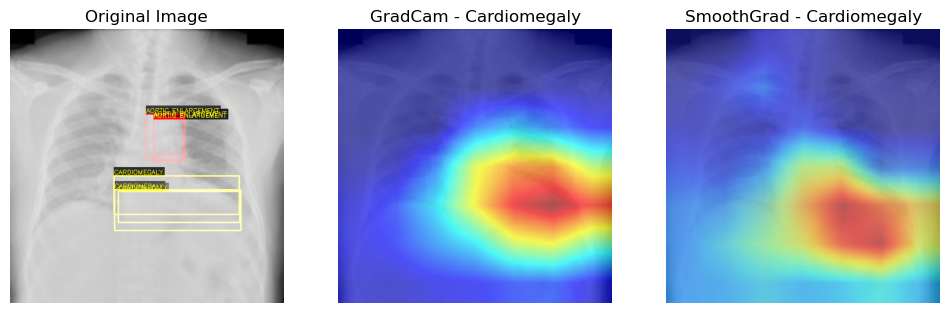

In [25]:
s_ht = smooth_cam[1]
ht = heatmap[1]

if heatmap.shape[0]==1:
    l = pred_label.item()
else:
    l = pred_label[1].detach().cpu().numpy()
#print(img.shape)
img = img_show(image.detach().cpu().squeeze())

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(output)
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(ht.detach().cpu().numpy())
plt.title('GradCam - {}'.format(class_predicted[int(l)]))
plt.axis('off')

plt.subplot(133)
plt.imshow(s_ht.detach().cpu().numpy())
plt.title('SmoothGrad - {}'.format(class_predicted[int(l)]))
plt.axis('off')

# Save the plot with 
filename = 'SG_0.2' + ' ' + class_predicted[int(l)] + ' ' + 'plot{}'.format(int(idx.detach().cpu()))+'.png'
print(filename)
save_filename = os.path.join(save_dir, filename)
plt.savefig(save_filename)


plt.show()

#### Intesection Over Union (IoU)
To calculate the Intersection over Union (IoU) between a bounding box specified by (x,y,w,h) from a heatmap and another bounding box specified by (xmin, ymin, xmax, ymax) from the original image, you can use the following formula:
IoU = Area of intersection / Area of Union  
Here's how you can calculate the IoU:  
1. Calculate the coordinates of the intersection:
- x_intersection = maximum of x and xmin
- y_intersection = maximum of y and ymin
- w_intersection = minimum of (x+w) and xmam minus x_intersection
- h_intersection = minimum of (y+h) and ymax minus y_intersection
2. Check if there is an actul intersection by ensuring that both w_intersection and h_intersection are greater than 0. if either of them is less than or equal to 0, there is no intersection.
3. Calculate the are of intersection:
- area_intersection = w_intersection x h_intersection
4. Calculate the area of the bounding box
- area_box1 = w x h
- area_box2 = (xmax-xmin) x (ymax-ymin)
5. Calculate the area of union:
- area_union = area_box1 + area_box2
- area_intersection
6. Calculate the IoU:
- IoU = area_intersection / area_union

In [34]:
class IoUCalculator:
    def __init__(self, image, label, pred_label, heatmap_gray, class_id, boxes, get_most_important_pixes_gray):
        self.image=image
        self.label = label
        self.pred_label = pred_label
        self.heatmap_gray = heatmap_gray
        self.class_id = class_id
        #print(class_id)
        self.boxes = boxes
        self.get_most_important_pixels_gray = get_most_important_pixels_gray
        
       
    def box_coordinates(self):
        # Create a dictionary, keys: class_id, values: a list of the boxes coordinates for each class_id
        box_dict={}
        #print(class_id)
        # Iterate through each row in the arrays
        for i in range(len(self.class_id.values)):
            c_id = class_id.values[i].item()
            box_coordinates = self.boxes.values[i]
            # if the class_id is not already in the dictionary add
            if c_id not in box_dict:
                box_dict[c_id] = []
            # Append the bounding box coordinates to the correstpondind class_id key
            box_dict[c_id].append(box_coordinates)

#         # Find the mean values of the coordinates, because of different annotators
#         b_mean={}    
#         for c, cor in box_dict.items():
#             # Convert the list of Numpy arrays to a single Numpy array
#             cor_array = np.array(cor)
#             # Calculate the mena value along axis 0 to get the mean
#             cor_mean = np.mean(cor_array, axis=0)
#             # Store the b_mean in the new dictionary
#             b_mean[c] = cor_mean
        return box_dict



     
    def create_bounding_boxes(self, mask):
        mask = mask.detach().cpu().numpy().astype('uint8') # 224, 224, max: 255, min: 0
        mask = cv2.resize(mask, (512,512)) # shape: 512,512
        #print(f'The shape of the mask is: {mask.shape}')
        contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # list of points defining the contour's shape
        for contour in contours:
            # Find the bounding box
            x,y,w,h = cv2.boundingRect(contour)
            
            # Draw the bounding box in an image for visualization
            # cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0))
        #print(f'For the bounding box x is: {x}, y is: {y}, width is: {w} and height is: {h}')
        return x,y,w,h
  
    
    def calculate_iou(self, x,y,w,h, xmin, ymin, xmax, ymax):
        x_intersection = max(x, xmin)
        y_intersection = max(y, ymin)
        w_intersection = min(x+w, xmax) - (x_intersection)
        h_intersection = min(y+h, ymax) - (y_intersection)

        if w_intersection <= 0 or h_intersection <= 0:
            return 0.0

        area_intersection = w_intersection * h_intersection
        area_box1 = w*h
        area_box2 = (xmax-xmin)*(ymax-ymin)
        area_union = area_box1 + area_box2 - area_intersection

        iou = area_intersection / area_union

        return iou
    
    def calculate_iou_results(self, percentages):
        l = self.label.squeeze()
        true_label = torch.where(l == 1)[0]
        
        common_class_ids_initial = []

        # Create a list with the common labels between pred_label and true label
        # Check if pred_label is a scalar tensor
        if self.pred_label.dim() == 0:
            common_class_ids_initial.extend(list(set(true_label.tolist()) & set([self.pred_label.item()])))
        else:
            for val in self.pred_label:
                common_class_ids_initial.extend(list(set(true_label.tolist()) & set([val.item()])))
        
        #print(f'The initial common_class_ids are: {common_class_ids_initial}')
       
        common_class_ids_initial = torch.tensor(common_class_ids_initial, dtype=torch.int64)
        #print(f'The initial common_class_ids are: {common_class_ids_initial}')
        indices = torch.where(torch.isin(pred_label.detach().cpu(), common_class_ids_initial))[0]
        #print(f'The indices are: {indices}')

        # Map the labels of the true_label with the original labels used in the dataset
        value_mapping = {0: 0, 1: 3, 2: 7, 3: 10, 4: 11, 5: 13, 6: 14}
        common_class_ids = torch.tensor([value_mapping[val.item()] for val in common_class_ids_initial])
        #print(f'The common class_ids are: {common_class_ids}')

        # Create a dictionary to store IoU results
        iou_results = {}
        
        # Check if common_class_ids is not empty (contains at least one label)
        if len(common_class_ids)>0:
            
            # Create boxes, box: the dict with keys: class_id and values: the box coordinates
            box = self.box_coordinates()
            #print(box)

            # Iterate over the percentages
            for pcg in percentages:
                # Create a dict to store the iou values for each class_id
                iou = {}
                for hi, i in enumerate(common_class_ids.detach().cpu().numpy()):
                    
                    boxes_id = box[i]
                    #print(boxes_id)
                    mask = self.get_most_important_pixels_gray(self.heatmap_gray[indices[hi]], pcg)
                    x, y, w, h = self.create_bounding_boxes(mask)
                    # Initialize a list to store IoU values for each box
                    iou_values = []
                    # Calculate IoU for each true box
                    for b in boxes_id:
                        #print(b)
                        iou_c = self.calculate_iou(x, y, w, h, int(b[0]), int(b[1]), int(b[2]), int(b[3]))
                        iou_values.append(iou_c)

                    # Calculate the mean IoU for this class_id
                    mean_iou = np.round(np.mean(iou_values), 3)
                    iou[i] = mean_iou

                # Store the results for the current percentages
                iou_results[pcg] = iou

        return iou_results

In [45]:
heatmap_gray.shape, label

(torch.Size([4, 224, 224]), tensor([[1, 1, 0, 0, 0, 0, 0]]))

In [41]:
# Initialize the class with label, pred_label and heatmap_gray
#print(class_id)
#print(len(class_id.values))
iou_calculator = IoUCalculator(img, label, pred_label, heatmap_gray, class_id, boxes, get_most_important_pixels_gray)

# Define the percentages to calculate IoU
percentages = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2]

# Calculate IoU results
results = iou_calculator.calculate_iou_results(percentages)


print(results)

{0.01: {0: 0.425, 3: 0.076}, 0.02: {0: 0.611, 3: 0.11}, 0.03: {0: 0.605, 3: 0.133}, 0.05: {0: 0.415, 3: 0.193}, 0.08: {0: 0.273, 3: 0.273}, 0.1: {0: 0.217, 3: 0.312}, 0.2: {0: 0.105, 3: 0.279}}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The heatmap_gray shape is: torch.Size([4, 224, 224]), and the box has length: 4
IoUP - 0.01 Aortic enlargement plot159.png


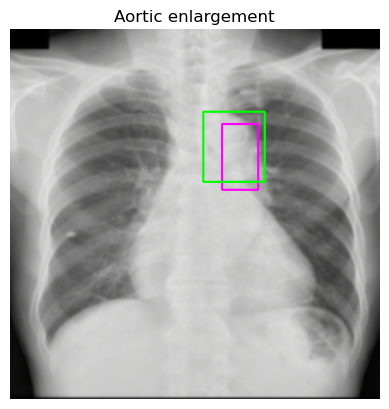

In [49]:
# 0: 0, 1: 3, 2: 7, 3: 10, 4: 11, 5: 13, 6: 14
l = pred_label[0].detach().cpu().numpy()
#print(l)
def plot_bounding_box(img, x,y,w,h,b,l,pcg):
    image=img.copy()
    image = cv2.resize(image, (512,512))
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 255), 2)
    cv2.rectangle(image, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), (0,255,0), 2)
    plt.imshow(image, cmap='gray')
    plt.title(class_predicted[int(l)])
    plt.axis('off')
    filename = 'IoUP - {}'.format(pcg) + ' ' + class_predicted[int(l)] + ' ' + 'plot{}.png'.format(int(idx))
    print(filename)
    save_filename = os.path.join(save_dir, filename)
    plt.savefig(save_filename)
    plt.show()

# Call the box_coordinates to obtain the bounding box coordinates of ground truth boxes
box = iou_calculator.box_coordinates()
#print(box
pcg = 0.01
print(f'The heatmap_gray shape is: {heatmap_gray.shape}, and the box has length: {len(box)}')

# Get the most imoprtant pixels of heatmap_gray
mask = get_most_important_pixels_gray(heatmap_gray[0], pcg)

# calculate the predicted bounded boxes
x,y,w,h = iou_calculator.create_bounding_boxes(mask)

# Plot the images with the two boxes
plot_bounding_box(img, x,y,w,h, box[0][0],l,pcg)

In [50]:
'''In this section the mean iou for each percentage for each class is computed taking into account 
the different annotators'''


import json # For JSON serialization, JavaScript Object Notation
import pickle # for binary serialization


# Initialize the class with label, pred_label and heatmap_gray
iou_calculator = IoUCalculator(img, label, pred_label, heatmap_gray, class_id, boxes, get_most_important_pixels_gray)
# Define the percentages to calculate IoU
percentages = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2]

# Initialize a dictionary to store results for each percentage
iou_results_by_percentage = {pcg: {} for pcg in percentages}


# Iterate through the testloader
for img, label, bbox, idx in testloader:
    if label[0,6] !=0:
        continue # Skip processing the image
        
    # Compute the heatmap and other values for the current image
    img.requires_grad_()
    #print(img.type())
    heatmap, heatmap_gray, pred_label, pred, pred_all_c = heatmaps(img.to(device), model.to(device), 0.65)
    if (pred_label == 6).any():
        continue # Skip processing the image
        
    # Get the respective boxes
    boxes, class_id = get_boxes(DATA_DIR, idx, boxes_dir)
   
    # Update the label and pred_label with the values for the current image
    iou_calculator.label = label
    iou_calculator.pred_label = pred_label
    iou_calculator.heatmap_gray = heatmap_gray
    iou_calculator.boxes = boxes
    iou_calculator.class_id = class_id
   
    # Calculate the results for the current image
    results = iou_calculator.calculate_iou_results(percentages)
    
    # Accumulate IoU values for each class
    for pcg, iou_dict in results.items():
        for class_id, iou_value in iou_dict.items():
            #print(class_id)
            if class_id not in iou_results_by_percentage[pcg]:
                iou_results_by_percentage[pcg][class_id]=[]
            iou_results_by_percentage[pcg][class_id].append(iou_value)
    
 # Calculate the mean IoU for each class and for each percentage
mean_iou_per_class_by_percentage = {}
for pcg, class_iou_dict in iou_results_by_percentage.items():
    mean_iou_per_class_by_percentage[pcg] = {}
    for class_id, iou_values in class_iou_dict.items():
        mean_iou = sum(iou_values)/len(iou_values)
        mean_iou_per_class_by_percentage[pcg][class_id] = np.round(mean_iou, 3)
        
print(mean_iou_per_class_by_percentage)

# # Save the results to a file using JSON
# with open('mean_iou_results.json', 'w') as json_file:
#     json.dump(mean_iou_per_class_by_percentage, json_file)
    
# # Save the results to a file using pickle
# with open('mean_iou_results.pkl', 'wb') as pickle_file:
#     pickle.dump(mean_iou_per_class_by_percentage, pickle_file)

{0.01: {10: 0.095, 11: 0.019, 0: 0.178, 3: 0.126, 7: 0.085, 13: 0.057}, 0.02: {10: 0.134, 11: 0.024, 0: 0.201, 3: 0.195, 7: 0.123, 13: 0.07}, 0.03: {10: 0.152, 11: 0.023, 0: 0.192, 3: 0.223, 7: 0.136, 13: 0.076}, 0.05: {10: 0.173, 11: 0.023, 0: 0.154, 3: 0.237, 7: 0.15, 13: 0.078}, 0.08: {10: 0.178, 11: 0.02, 0: 0.114, 3: 0.223, 7: 0.135, 13: 0.067}, 0.1: {10: 0.172, 11: 0.018, 0: 0.094, 3: 0.213, 7: 0.125, 13: 0.061}, 0.2: {10: 0.127, 11: 0.012, 0: 0.05, 3: 0.162, 7: 0.087, 13: 0.047}}


In [51]:
mean_iou_per_class_by_percentage

{0.01: {10: 0.095, 11: 0.019, 0: 0.178, 3: 0.126, 7: 0.085, 13: 0.057},
 0.02: {10: 0.134, 11: 0.024, 0: 0.201, 3: 0.195, 7: 0.123, 13: 0.07},
 0.03: {10: 0.152, 11: 0.023, 0: 0.192, 3: 0.223, 7: 0.136, 13: 0.076},
 0.05: {10: 0.173, 11: 0.023, 0: 0.154, 3: 0.237, 7: 0.15, 13: 0.078},
 0.08: {10: 0.178, 11: 0.02, 0: 0.114, 3: 0.223, 7: 0.135, 13: 0.067},
 0.1: {10: 0.172, 11: 0.018, 0: 0.094, 3: 0.213, 7: 0.125, 13: 0.061},
 0.2: {10: 0.127, 11: 0.012, 0: 0.05, 3: 0.162, 7: 0.087, 13: 0.047}}

In [52]:
import json # For JSON serialization, JavaScript Object Notation

# Load the previously saved results from the JSON file
with open('mean_iou_results.json', 'r') as json_file:
    mean_iou_per_class_by_percentage = json.load(json_file)

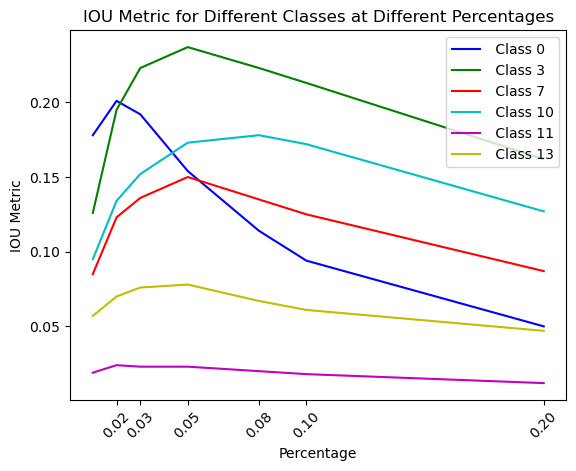

In [144]:
# Plot the IoU metric

# Define a list of class names and colors for each class
#c_names = ['0', '3', '7', '10', '11', '13']
c_names = [0, 3, 7, 10, 11, 13]
colors = ['b', 'g', 'r', 'c', 'm', 'y']


# Create a plot for each class
for c_index, c_name in enumerate(c_names):
    class_data = [mean_iou_per_class_by_percentage[percentage][c_name] for percentage in mean_iou_per_class_by_percentage.keys()]
    plt.plot(list(mean_iou_per_class_by_percentage.keys()), class_data, label = f' Class {c_name}', color=colors[c_index] )
    #print(class_data)
    #print(list(mean_iou_per_class_by_percentage.keys()))
# Add labels and legend
plt.grid
plt.xlabel('Percentage')
plt.ylabel('IOU Metric')
plt.title('IOU Metric for Different Classes at Different Percentages')
plt.legend()

# Specify the desired tick locations on the x-axis
desired_ticks = [0.02, 0.03, 0.05, 0.08, 0.1, 0.2]
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xticks(desired_ticks)

# # Add markers at the specified points
# for tick in desired_ticks:
#     plt.scatter([tick] * len(c_names), [mean_iou_per_class_by_percentage[tick][c_name] for c_name in c_names], color='black', marker='o')


# Save the plot with 
save_filename = os.path.join(save_dir, 'mean_iou_values')
plt.savefig(save_filename)

# Show the plot
plt.show()

In [69]:
# Convert keys to strings before saving as JSON
mean_iou_per_class_by_percentage_str_keys = {
    str(pcg): {
        str(class_id): mean_iou
        for class_id, mean_iou in class_iou_dict.items()
    }
    for pcg, class_iou_dict in mean_iou_per_class_by_percentage.items()
}

# Save the results to a file using JSON
with open('mean_iou_results.json', 'w') as json_file:
    json.dump(mean_iou_per_class_by_percentage_str_keys, json_file)

### Different masks

(224, 224, 3) 255 0


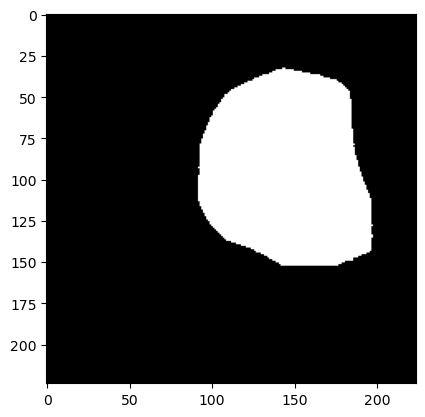

(224, 224, 3) 236 29 uint8


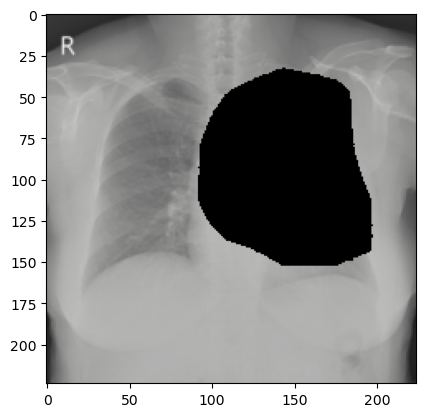

In [41]:
mask = get_most_important_pixels_gray(heatmap_gray[0], 0.2)
mask1 = mask.detach().cpu().numpy().astype('uint8')*255
#mask1 = cv2.resize(mask1, (512,512))
mask1 = cv2.cvtColor(mask1, cv2.COLOR_GRAY2RGB)
print(mask1.shape, mask1.max(), mask1.min())  #shape: 512,512,3
plt.imshow(mask1)
plt.show()

transformed_image = np.copy(img)
transformed_image = (transformed_image * 255).astype('uint8')
print(transformed_image.shape, transformed_image.max(), transformed_image.min(), transformed_image.dtype)
# Overlay the mask on the image
transformed_image[mask1 == 255] = [0]  # Set pixel values to black where mask is 255
#print(transformed_image.shape)
plt.imshow(transformed_image)
plt.show()

# histogram = cv2.calcHist([mask1], [0], None, [1], [0,1])
# # plt.imshow(mask)
# # plt.show()
# print(mask.dtype)
# histogram = cv2.calcHist([mask1], [0], None, [1.1], [0, 1.1])

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# plt.title("Histogram")
# plt.xlabel("Pixel Value")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.plot(histogram, color='black')

# # Show the histogram
# plt.show()

torch.Size([50176])
Shape of final mask: torch.Size([224, 224])
Shape of final 3-channel mask: torch.Size([224, 224, 3])


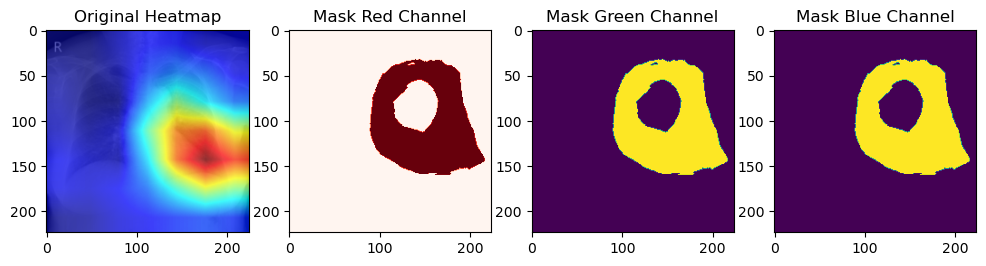

In [42]:
'''Get the mask in each of the 2 channels'''

def mask_RGB(ht, pcg):

    # Split the RGB heatmap into its individual color channels
    red_channel = ht[:, :, 0]
    green_channel = ht[:, :, 1]
    blue_channel = ht[:, :, 2]
    
    # Calculate pixel intensities separately for each channel
    red_intensities = red_channel
    green_intensities = green_channel
    blue_intensities = blue_channel
    
     # Calculate the combined intensity as a weighted sum of the channel intensities
    pixel_intensities = 0.2989 * red_intensities + 0.5870 * green_intensities + 0.1140 * blue_intensities
    
    # Flatten the intensities and get indices of the sorted pixels
    flattened_intensities = pixel_intensities.flatten()
    print(flattened_intensities.shape)
    sorted_indices = torch.argsort(flattened_intensities, descending=True)
    
    
    # Calculate the number of pixels to select (20% of total pixels)
    num_pixels_to_select = int(pcg * flattened_intensities.numel())

    # Create a boolean mask for the top 20% most important pixels
    mask = torch.zeros_like(flattened_intensities, dtype=torch.bool)
    mask[sorted_indices[:num_pixels_to_select]] = True

    # Reshape the mask to match the original heatmap dimensions
    final_mask = mask.view(ht.shape[:2])

    # Repeat the mask for each channel
    final_mask_3d = final_mask.unsqueeze(2).expand_as(ht)
    print(f"Shape of final mask: {final_mask.shape}")
    print(f"Shape of final 3-channel mask: {final_mask_3d.shape}")
    return final_mask_3d


final_mask_3d = mask_RGB(heatmap[0], 0.2)
#final_mask_3d = final_mask_3d.detach().cpu().numpy()

# Display the heatmap, grayscale heatmap, and 3 channels masks
plt.figure(figsize=(12, 4))  # Adjust the width and height as needed



plt.subplot(1,4,1)
plt.imshow(heatmap[1].detach().cpu().numpy())
plt.title('Original Heatmap')

plt.subplot(1,4,2)
plt.imshow(final_mask_3d[:,:,0], cmap='Reds')
plt.title('Mask Red Channel')


plt.subplot(1,4,3)
plt.imshow(final_mask_3d[:,:,1])
plt.title('Mask Green Channel')

plt.subplot(1,4,4)
plt.imshow(final_mask_3d[:,:,2])
plt.title('Mask Blue Channel')

plt.show()

In [43]:
''' Create final mask if numpy array'''
def final_mask_numpy(ht, pcg):
    # Numbers of pixels to select
    num_pixels_to_select = int(pcg*ht.size)
    print(num_pixels_to_select)
    # Flatten intensities and get the indices of sorted pixels
    htmap = np.clip(ht,0,1)
    flattend_heatmap = htmap.flatten()
    # sort the indices in descending order
    sorted_indices = np.argsort(flattened_heatmap)[::-1]
    # Create a boolean mask for the top pcg imortant pixels
    mask = np.zeros_like(flattened_heatmap, dtype=bool)
    mask[sorted_indices[:num_pixels_to_select]] = True
    # Reshape the mask to match the original heatmap dimensions
    final_mask = mask.reshape(htmap.shape)
    return final_mask

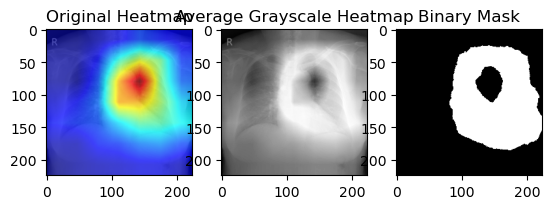

In [44]:
''' Find the hottest regions by performing averaging on the 3 channels'''

def averaging_heatmap(ht, threshold):
    average_heatmap = ht.mean(dim=-1) # Channel averaging
    normalized_heatmap = (average_heatmap-average_heatmap.min())/(average_heatmap.max() - average_heatmap.min())
    
    # Create a binary mask, adjust threshold as needed
    binary_mask = normalized_heatmap > threshold
    
    # Display the heatmap, grayscale heatmap, and binary mask
    plt.subplot(1,3,1)
    plt.imshow(ht.detach().cpu().numpy())
    plt.title('Original Heatmap')
    
    plt.subplot(1,3,2)
    plt.imshow(average_heatmap.detach().cpu().numpy(), cmap='gray')
    plt.title('Average Grayscale Heatmap')
    
    plt.subplot(1,3,3)
    plt.imshow(binary_mask.detach().cpu().numpy(), cmap='gray')
    plt.title('Binary Mask')
    
    plt.show()
    
averaging_heatmap(heatmap[0], 0.7)
    

C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


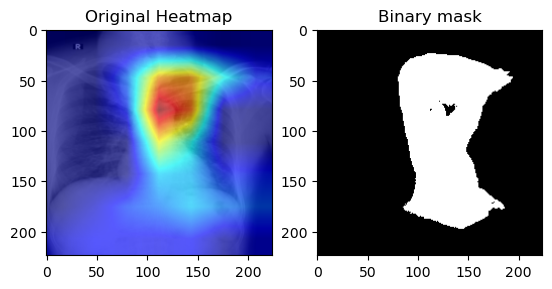

In [67]:
'''Find the most hot regions by performing clustering with RGB heatmaps'''

from sklearn.cluster import KMeans

def create_cluster_max(ht, n_clusters):
    # Flatten heatmap
    flattened_heatmap = ht.reshape((-1,3)) # Shape: (224*224, 3)
    flattened_heatmap = flattened_heatmap.detach().cpu().numpy()
    
    # Perform clustering (adjust n_clusters as needed)
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(flattened_heatmap)
    
    # Identify the hootest cluster(s)
    hottest_cluster_index = np.argmax(np.sum(kmeans.cluster_centers_, axis=1))
    
    # Create a binary mask based on the hottest cluster
    cluster_labels = kmeans.labels_
    binary_mask = cluster_labels == hottest_cluster_index
    binary_mask = binary_mask.reshape((224,224)) # Reshape back to (224,224)
    
    # Display the heatmap and binary mask
    plt.subplot(1,2,1)
    plt.imshow(ht.detach().cpu().numpy())
    plt.title('Original Heatmap')
    
    plt.subplot(1,2,2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary mask')
    plt.show()

create_cluster_max(heatmap[0], 2)

In [68]:
class_predicted

{0: 'Aortic enlargement',
 1: 'Cardiomegaly',
 2: 'Lung Opacity',
 3: 'Pleural effusion',
 4: 'Pleural thickening',
 5: 'Pulmonary fibrosis',
 6: 'No finding'}

### Replace of images and calculation of the new predictions

In [48]:
img.shape

(224, 224, 3)

In [49]:
def replaced_image(img, mask, transform, kernel_size, blur_type='gaussian'):
    img = cv2.resize(img,(224,224))
    if blur_type == 'gaussian':
        # Define the gaussian kernel 
        kernel_size = kernel_size
        # Perform Gaussian blurring
        blurred_image = cv2.GaussianBlur(img, kernel_size, cv2.BORDER_DEFAULT)
        # Transform image and blurred_image to tensor to be compatible with mask and model
        img = transform(img)
        blurred_image = transform(blurred_image)
        img = img.unsqueeze(dim=0)
        blurred_image = blurred_image.unsqueeze(dim=0)
        #print(f'The shape of the transformed image and blurred image is : {img.shape, blurred_image.shape}')
        # Apply the mask to the blurred image
        img_replaced = torch.where(mask, blurred_image, img)
    else:
        #print(img.shape)
        img = transform(img)
        img = img.unsqueeze(dim=0)
        #mean_vals = np.mean(img, keepdims=True)
        #print(img.shape)
        mean_vals = torch.mean(img, dim=(2,3), keepdim=True)
        # Replace the masked pixels with the mean values
        img_replaced = torch.where(mask, mean_vals, img)
    return img_replaced

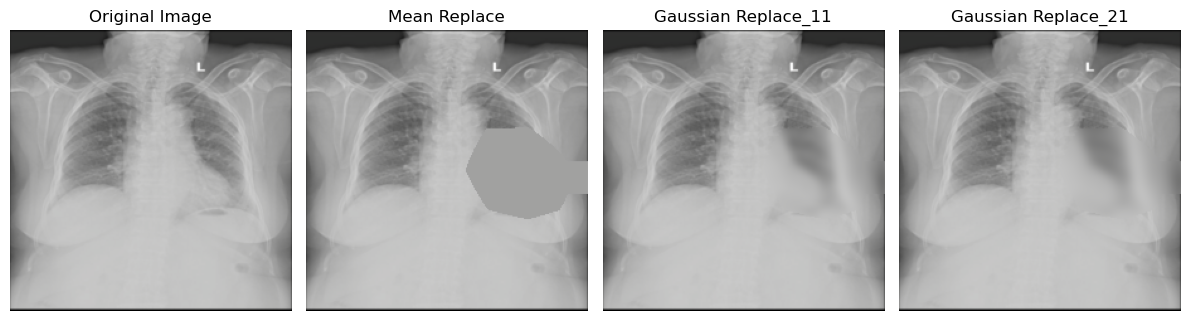

In [56]:
'''Plot the different transformations'''

mask = get_most_important_pixels_gray(heatmap_gray[1], 0.1)
transform = transforms.ToTensor()
img_replaced_1 = replaced_image(img, mask, transform, kernel_size='None', blur_type = 'mean')
#print(img_replaced_1.shape)
img_replaced_2 = replaced_image(img, mask, transform, kernel_size=(11,11))
img_replaced_3 = replaced_image(img, mask, transform, kernel_size=(21,21))


# Create a figure and axis with a larger size
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# Plot the images
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_replaced_1.squeeze().permute(1, 2, 0))
axes[1].set_title('Mean Replace')
axes[1].axis('off')

axes[2].imshow(img_replaced_2.squeeze().permute(1, 2, 0))
axes[2].set_title('Gaussian Replace_11')
axes[2].axis('off')

axes[3].imshow(img_replaced_3.squeeze().permute(1, 2, 0))
axes[3].set_title('Gaussian Replace_21')
axes[3].axis('off')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Save the plots
save_filename = os.path.join(save_dir, 'Images_Transformed.png' )
plt.savefig(save_filename, bbox_inches='tight', pad_inches=0.1)

# Show the plots
plt.show()


In [60]:
pcg=[0.05, 0.1, 0.2, 0.5]

transform = transforms.ToTensor()
#print(f'The original prediction is: {pred_all_c}')
imgs_replaced = torch.Tensor(len(pcg), heatmap_gray.shape[0], 1, 3, 224, 224)  
for j, p in enumerate(pcg):
    for i in range(heatmap_gray.shape[0]):
        mask = get_most_important_pixels_gray(heatmap_gray[i], p)
        imgs_replaced[j,i] = replaced_image(img, mask, transform, kernel_size='None', blur_type = 'mean') # [pcg, heatmaps, 1, 3, 224, 224]

In [61]:
pred_label, pred_all_c, pred, heatmap_gray.shape, imgs_replaced.shape

(tensor([0, 1], device='cuda:0'),
 tensor([0.9965, 0.9993, 0.4679, 0.0463, 0.5118, 0.3665, 0.0087],
        device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([0.9965, 0.9993], device='cuda:0', grad_fn=<MaskedSelectBackward0>),
 torch.Size([2, 224, 224]),
 torch.Size([4, 2, 1, 3, 224, 224]))

In [62]:
def prediction_drop(imgs_replaced, pred_original, pcg):
    '''returns a nested dictionary:
    key_values1 - percnetages
    key_values2 - the label for the image replaced
    item - the new predictions for the specific replaced image'''
    
    prediction_diff = {}
    for j, p in enumerate(pcg): # Iterate over the predicted labels
        predictions_diff_label = {}
        for i in range(imgs_replaced.shape[1]): # Iterate over the predicted labels
            pred_replaced = model(imgs_replaced[j,i].to(device).requires_grad_())
            pred_replaced = torch.sigmoid(pred_replaced)[0].detach().cpu().numpy().astype('float')
            
            # Take the difference
            #pred_original = pred_original[0].detach().cpu().numpy().astype('float')
            diff = pred_original.detach().cpu().numpy() - pred_replaced
            # Store the differences for this label in the dictionary
            predictions_diff_label[i] = diff
            
        # Store the differences for this percentage in the main dictionary
        prediction_diff[p] = predictions_diff_label
    return prediction_diff

In [63]:
import itertools
import json

'''Prediction_diff_sum is a nested dictionary with outer keys: pcgs, inner keys: labels and values: 7th element list
   of the prediction drop for each class and image of the testloader'''

# The percentages of pixels transformed
pcg = [0.02, 0.05, 0.1, 0.2, 0.5]
prediction_diff_sum={p: {l: [] for l in class_predicted.keys()} for p in pcg}
limited_testloader = itertools.islice(testloader, 10)

for batch in tqdm(testloader):
    image, label, bbox, idx = batch
    image.requires_grad_()
    #print(label)
    # pred_label is the idx of the predicted tensor
    # pred_all_c is the predictions for all the classes, heatmap_gray is the heatmap in order to take the masks
    _, heatmap_gray, pred_label, _, pred_all_c = heatmaps(image.to(device), model.to(device), 0.7)
    pred_label = pred_label.detach().cpu().numpy()
    if heatmap_gray.shape[0]==1:
        pred_label = pred_label.item()
    else:
        pred_label = pred_label.astype(int)
        #print(pred_label)
    
    invalid_values = np.isnan(heatmap_gray) | np.isinf(heatmap_gray)
    if invalid_values.any():
        continue
    
    # Take the replaced images for each predicted label and percentages
    transform = transforms.ToTensor()
    imgs_replaced = torch.Tensor(len(pcg), heatmap_gray.shape[0], 1, 3, 224, 224)
    img = img_show(image.detach().cpu().squeeze())

    for j, p in enumerate(pcg):
        for i in range(heatmap_gray.shape[0]):
            mask = get_most_important_pixels_gray(heatmap_gray[i], p)
            #print(mask.shape)
            # here we choose the transforamation we want: kernel_size=(11,11), kernel_size=(21,21) or kernel_size='None', blur_type='mean'
            imgs_replaced[j, i] = replaced_image(img, mask, transform, kernel_size=(21,21))
            
                        
    pd = prediction_drop(imgs_replaced, pred_all_c, pcg)
    #print(pd)
    for p, values in pd.items():
        for l, pred in values.items():
            if heatmap_gray.shape[0]==1:
                prediction_diff_sum[p][pred_label].append(pred)
            else:
                #pred_label=pred_label[l]
                #print(l)
                    
                prediction_diff_sum[p][pred_label[l]].append(pred)



  0%|          | 3/1480 [00:00<04:41,  5.24it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
  0%|          | 4/1480 [00:00<04:41,  5.24it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
  1%|          | 8/1480 [00:02<08:43,  2.81it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
  1%|          | 9/1480 [00:02<07:22,  3.33it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
  1%|          | 15/1480

 15%|█▌        | 229/1480 [01:10<06:45,  3.09it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 16%|█▌        | 235/1480 [01:11<06:15,  3.32it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 16%|█▌        | 238/1480 [01:12<09:07,  2.27it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 17%|█▋        | 248/1480 [01:15<05:44,  3.57it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 17%|█▋        |

 40%|███▉      | 586/1480 [03:01<03:33,  4.18it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 40%|███▉      | 589/1480 [03:02<05:20,  2.78it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 41%|████      | 603/1480 [03:05<03:09,  4.63it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 41%|████      | 607/1480 [03:06<03:04,  4.74it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 42%|████▏     |

 60%|█████▉    | 882/1480 [04:32<02:06,  4.71it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 60%|██████    | 890/1480 [04:35<03:02,  3.24it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 60%|██████    | 895/1480 [04:36<02:55,  3.33it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 61%|██████    | 896/1480 [04:37<02:34,  3.77it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 61%|██████    |

 84%|████████▍ | 1244/1480 [06:28<00:59,  3.95it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 85%|████████▍ | 1251/1480 [06:30<01:09,  3.30it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 85%|████████▌ | 1259/1480 [06:34<01:58,  1.86it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 86%|████████▌ | 1275/1480 [06:39<01:18,  2.61it/s]C:\Users\Theodora\AppData\Local\Temp\ipykernel_20240\2314508949.py:6: RuntimeWarning: invalid value encountered in cast
  resized_heatmap = np.clip(255 * resized_heatmap, 0, 255).astype(np.uint8)
 86%|███████

In [54]:
import json

# Convert NumPy arrays to Python lists in the dictionary
def convert_numpy_arrays(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


def convert_keys_to_numbers(pairs):
    result = {}
    for key, value in pairs:
        # Convert keys to numbers if possible
        try:
            key = int(key)
        except ValueError:
            try:
                key = float(key)
            except ValueError:
                pass
        # Recursively convert nested dictionaries
        if isinstance(value, list):
            value = [convert_keys_to_numbers(item) if isinstance(item, dict) else item for item in value]
        elif isinstance(value, dict):
            value = convert_keys_to_numbers(value.items())
        result[key] = value
    return result


In [65]:
# Save the dictionary to a JSON file
# here there are 3 possible saves: prediction_diff_sum_mean, prediction_diff_sum_gaussian and prediction_diff_sum_gaussian_21
with open('prediction_diff_sum_gaussian_21.json', 'w') as f:
    json.dump(prediction_diff_sum, f, default=convert_numpy_arrays)

In [55]:
with open('prediction_diff_sum_gaussian_21.json', 'r') as f:
    prediction_diff_sum = json.load(f, object_pairs_hook = convert_keys_to_numbers)

In [56]:
len(prediction_diff_sum[0.5][3]), prediction_diff_sum[0.5].keys(), prediction_diff_sum.keys()

(159, dict_keys([0, 1, 2, 3, 4, 5, 6]))

In [73]:
'''Mean values is a nested dict: keys:pcgs, inner_keys: classes, values: mean drop for each class'''

# Initialize a dictionary to store mean values
mean_values = {}
# Iterate over percentages
for p, values in prediction_diff_sum.items():
    mean_values[p] = {}
    # Iterate over labels
    for l, preds in values.items():
        # Convert the list of arrays to a numpy array for eacy manipulation
        predictions_array = np.array(preds)
        # Calculate the mean along the first axis(axis=0)
        mean_values[p][l] = np.mean(predictions_array, axis=0)

# Replce the keys of the nested dictionary with the original class ids
c_mapping = {0:0, 1:3, 2:7, 3:10, 4:11, 5:13, 6:14}
mean_values = {
                old_key: {c_mapping[c]: value for c, value in c.items()}
    for old_key, c in mean_values.items()
                }

# 3 options here: mean_values_mean, mean_values_gaussian, mean_values_gaussian_21
with open('mean_values_gaussian_21.json', 'w') as f:
    json.dump(mean_values, f, default = convert_numpy_arrays)

In [61]:
save_dir = '../outputs'
# Open the mean values for each pcg as mean_values to create the plots for each transformation
with open('mean_values_gaussian_21.json', 'r') as f:
    mean_values = json.load(f, object_pairs_hook = convert_keys_to_numbers)

[0, 3, 7, 10, 11, 13, 14]


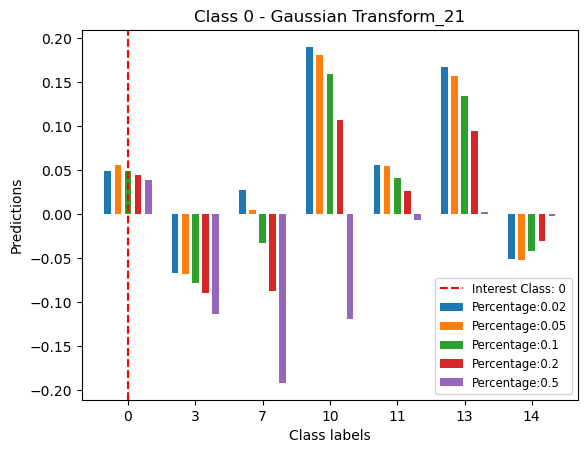

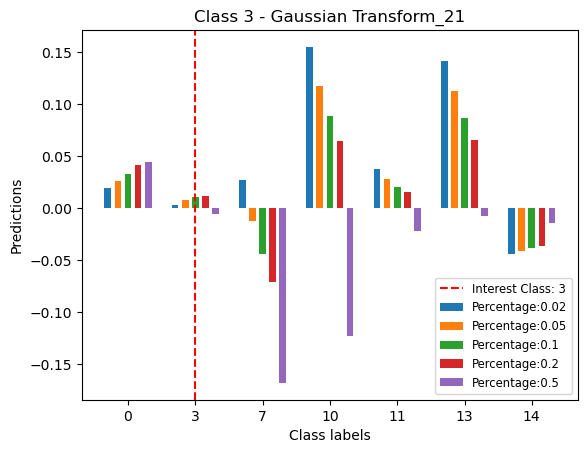

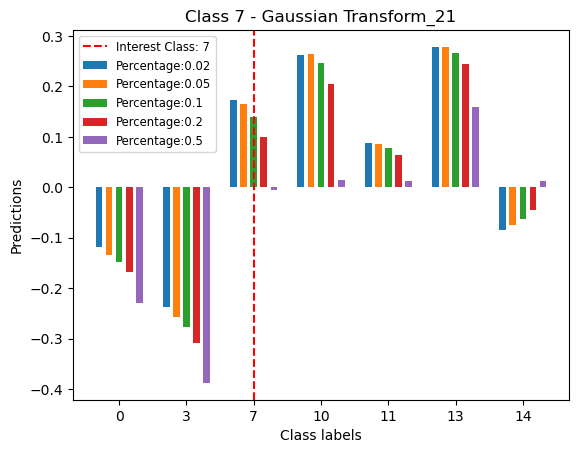

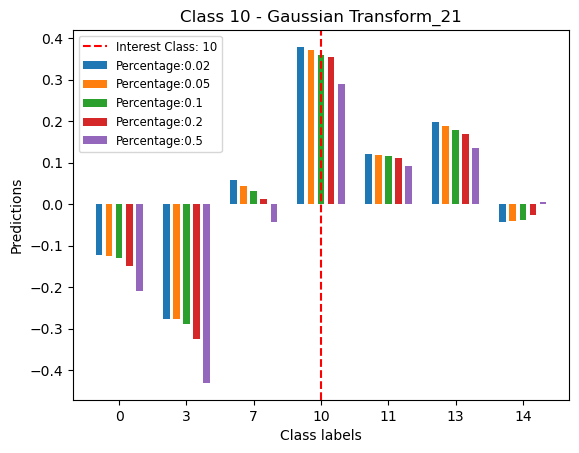

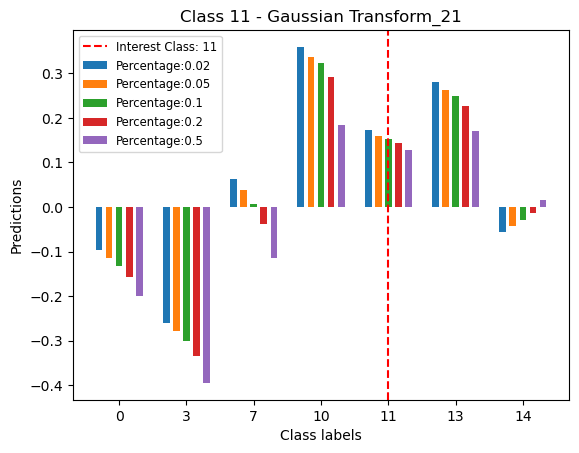

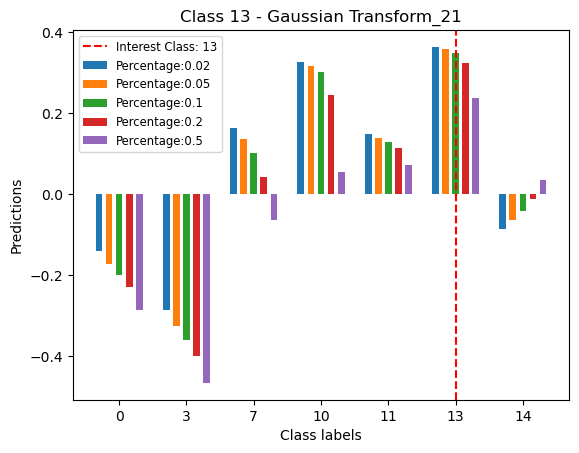

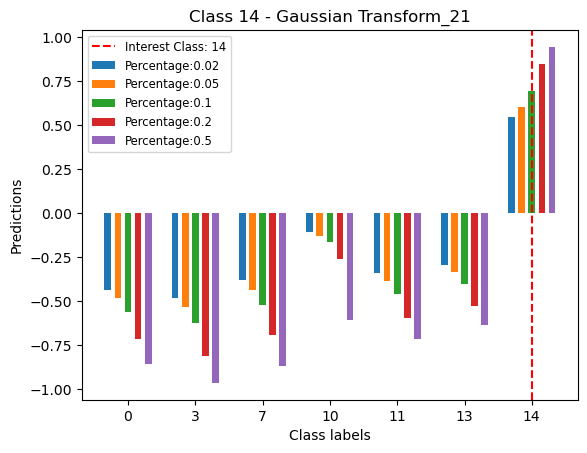

In [76]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Get the unique class labels
class_labels = list(mean_values[0.02].keys())
print(class_labels)

# Set the width of the bars
bar_width = 0.1  # Adjust this value based on your preference
bar_offsets = np.linspace(-0.3, 0.3, len(mean_values))  # Adjust the offset range based on your data

# Iterate over class labels
for i, class_label in enumerate(class_labels):
    #print(i, class_label)
    plt.figure()  # Create a new figure for each class
    plt.title(f'Class {class_label} - Gaussian Transform_21')

    # Iterate over percentages and corresponding predictions
    for j, (p, predictions) in enumerate(mean_values.items()):
        # Extract predictions for the current class label
        preds = predictions[class_label]

        # Calculate the x position for the bars
        x_positions = np.arange(len(class_labels)) + bar_offsets[j]

        # Plot predictions for the current percentage and class label using grouped bar plot
        plt.bar(x_positions, preds, width=bar_width, label=f'Percentage:{p}')
        
    
    # Draw a vertical line at the position of the class of interest
    #class_position = class_labels.index(interested_class) + 0.5  # Adjust for the bar width
    plt.axvline(x=i, color='red', linestyle='--', label=f'Interest Class: {class_label}')


    # Set the labels for the x and y axes
    plt.xlabel('Class labels')
    plt.ylabel('Predictions')

    # Set custom x-axis labels
    plt.xticks(np.arange(len(class_labels)), class_labels)

    # Set legend to display percentage information
    plt.legend(fontsize='small')

    # Save the plot
    save_filename = os.path.join(save_dir, f'class_{class_label}_gaussian_21_barplot.png')
    plt.savefig(save_filename)

# Show all plots
plt.show()

